In [ ]:
# Importing important libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re, string, time
from sklearn.model_selection import train_test_split
from sklearn import metrics
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Dropout, SimpleRNN, GRU
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Download dataset
import kagglehub
path = kagglehub.dataset_download("venky73/spam-mails-dataset")
print("Download dataset path",path)

Using Colab cache for faster access to the 'spam-mails-dataset' dataset.
Download dataset path /kaggle/input/spam-mails-dataset


In [ ]:
# Extracting the data
import pandas as pd
df = pd.read_csv(path + "/spam_ham_dataset.csv")
display(df.head())

,Unnamed: 0,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs\r\nthis deal is t...,0


In [ ]:
# Extracting the data
import pandas as pd
df = pd.read_csv(path + "/spam_ham_dataset.csv", usecols=['text', 'label'])
display(df.head())

,label,text
0,ham,Subject: enron methanol ; meter # : 988291\r\n...
1,ham,"Subject: hpl nom for january 9 , 2001\r\n( see..."
2,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar..."
3,spam,"Subject: photoshop , windows , office . cheap ..."
4,ham,Subject: re : indian springs\r\nthis deal is t...


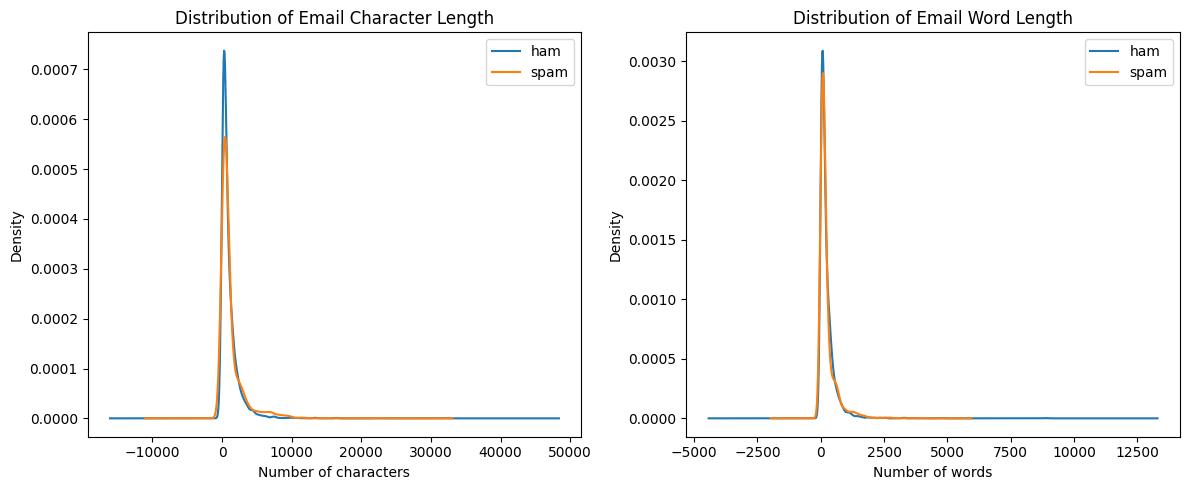

In [ ]:

# Calculate length features
df["char_length"] = df["text"].apply(len)                  # number of characters
df["word_length"] = df["text"].apply(lambda x: len(x.split()))  # number of words

# Plot distributions by class
plt.figure(figsize=(12,5))

# Characters
plt.subplot(1,2,1)
for label in df["label"].unique():
    df[df["label"]==label]["char_length"].plot(kind='kde', label=label)
plt.title("Distribution of Email Character Length")
plt.xlabel("Number of characters")
plt.legend()

# Words
plt.subplot(1,2,2)
for label in df["label"].unique():
    df[df["label"]==label]["word_length"].plot(kind='kde', label=label)
plt.title("Distribution of Email Word Length")
plt.xlabel("Number of words")
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
# Getting the proportion of values
df['label'].value_counts(normalize = True)

,proportion
label,
ham,0.710114
spam,0.289886


**This is (71:29) not a severe imbalance. Lets try without resampling**

In [ ]:
# Cleaning
def clean_text(text):
    text = text.lower()
    text = re.sub(r"<.*>", " ", text)
    text = text.translate(str.maketrans("", "", string.punctuation))
    text = re.sub(r"\d+", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

In [ ]:
# Applying the function
df['clean_text'] = df['text'].apply(clean_text)
df['label'] = df['label'].map({'ham': 0, 'spam': 1})
df.head()

,label,text,char_length,word_length,clean_text
0,0,Subject: enron methanol ; meter # : 988291\r\n...,327,67,subject enron methanol meter this is a follow ...
1,0,"Subject: hpl nom for january 9 , 2001\r\n( see...",97,23,subject hpl nom for january see attached file ...
2,0,"Subject: neon retreat\r\nho ho ho , we ' re ar...",2524,550,subject neon retreat ho ho ho we re around to ...
3,1,"Subject: photoshop , windows , office . cheap ...",414,48,subject photoshop windows office cheap main tr...
4,0,Subject: re : indian springs\r\nthis deal is t...,336,70,subject re indian springs this deal is to book...


In [ ]:
# 2 Sample

ham_df = df[df['label'] == 0]
spam_df = df[df['label'] == 1]

print("==== HAM SAMPLES ====")
for i, row in ham_df.sample(n=min(2, len(ham_df)), random_state=42).iterrows():
    print(f"[{i}] {row['clean_text']}\n")

print("==== SPAM SAMPLES ====")
for i, row in spam_df.sample(n=min(2, len(spam_df)), random_state=42).iterrows():
    print(f"[{i}] {row['clean_text']}\n")


==== HAM SAMPLES ====
[2977] subject conoco big cowboy darren i m not sure if you can help me with this but i don t know who else to ask for april and may we have gas pathed on deal to conoco at the gepl big cowboy point conoco is saying that we did not buy that gas from them they have accounted for all of the hpl big cowboy gas and think we have over paid by about mil each month for the gepl gas do you know why we added the gepl meter to the deal in april could we have bought this gas from someone else i have the meter statements from tejas but they do not say who the supply company was megan

[3822] subject feb prod sale to teco gas processing sale deal expired julie this deal has expired for teco gas processing but we did have a sale in should this deal be extended pls let me know so that i can redraft the sale through unify katherine unable to draft volume in unify due to the expired deal ticket

==== SPAM SAMPLES ====
[3927] subject liffe is great hello vlsit our medsbymail shop a

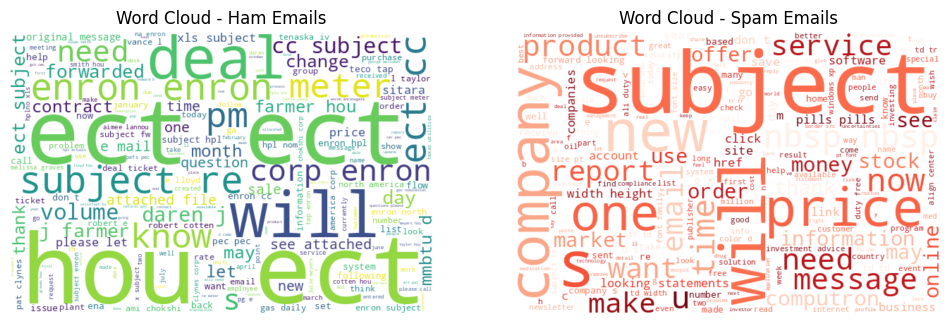

In [ ]:
from wordcloud import WordCloud

ham_text = " ".join(df[df['label'] == 0]['clean_text'])
spam_text = " ".join(df[df['label'] == 1]['clean_text'])

plt.figure(figsize=(12,6))

# Ham
plt.subplot(1,2,1)
if ham_text: # Check if ham_text is not empty
    wc_ham = WordCloud(width=600, height=400, background_color='white').generate(ham_text)
    plt.imshow(wc_ham, interpolation='bilinear')
    plt.axis('off')
    plt.title("Word Cloud - Ham Emails")
else:
    print("Ham text is empty, cannot generate word cloud.")
    plt.text(0.5, 0.5, "No Ham Word Cloud (text empty)", horizontalalignment='center', verticalalignment='center')
    plt.axis('off')


# Spam
plt.subplot(1,2,2)
if spam_text: # Check if spam_text is not empty
    wc_spam = WordCloud(width=600, height=400, background_color='white', colormap='Reds').generate(spam_text)
    plt.imshow(wc_spam, interpolation='bilinear')
    plt.axis('off')
    plt.title("Word Cloud - Spam Emails")
else:
    print("Spam text is empty, cannot generate word cloud.")
    plt.text(0.5, 0.5, "No Spam Word Cloud (text empty)", horizontalalignment='center', verticalalignment='center')
    plt.axis('off')


plt.show()

In [ ]:
# Fine Tune Vocab and Maxlen
vocab_size = 15000
maxlen = 200

tokenizer = Tokenizer(num_words = vocab_size, oov_token = '')
tokenizer.fit_on_texts(df['clean_text'])

In [ ]:
# Creating input features and target variable
X = tokenizer.texts_to_sequences(df['clean_text'])
X = pad_sequences(X, maxlen = maxlen, padding = 'post', truncating = 'post')
y = df['label'].values

In [ ]:
# Performing train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [ ]:
# Model Builders
embedding_dim = 128
early_stop = EarlyStopping(monitor = 'val_loss', patience = 3, restore_best_weights = True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 1, min_lr = 0.001)

In [ ]:
# Defining the function for SimpleRNN
def build_rnn(units_list = [64], dropout = 0.3):
  model = Sequential()
  model.add(Embedding(vocab_size, embedding_dim, input_length = maxlen))
  for i, units in enumerate(units_list):
    model.add(SimpleRNN(units, activation = 'relu', return_sequences = (i < len(units_list) - 1)))
    model.add(Dropout(dropout))
  model.add(Dense(1, activation = 'sigmoid'))
  model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
  return model

In [ ]:
# Defining the function for LSTM
def build_lstm(units_list = [64], dropout = 0.3):
  model = Sequential()
  model.add(Embedding(vocab_size, embedding_dim, input_length = maxlen))
  for i, units in enumerate(units_list):
    model.add(LSTM(units, activation = 'relu', return_sequences = (i < len(units_list) - 1)))
    model.add(Dropout(dropout))
  model.add(Dense(1, activation = 'sigmoid'))
  model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
  return model

In [ ]:
# Defining the function for GRU
def build_gru(units_list = [64], dropout = 0.3):
  model = Sequential()
  model.add(Embedding(vocab_size, embedding_dim, input_length = maxlen))
  for i, units in enumerate(units_list):
    model.add(GRU(units, activation = 'relu', return_sequences = (i < len(units_list) - 1)))
    model.add(Dropout(dropout))
  model.add(Dense(1, activation = 'sigmoid'))
  model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
  return model

In [ ]:
# Variants of the model
configs = [
    # RNN Variants
    ("RNN-32", build_rnn([32], 0.2)),
    ("RNN-64-32", build_rnn([64, 32], 0.3)),
    ("RNN-128-64-32", build_rnn([128, 64, 32], 0.5)),

    # LSTM Variants
    ("LSTM-32", build_lstm([32], 0.2)),
    ("LSTM-64-32", build_lstm([64, 32], 0.3)),
    ("LSTM-128-64-32", build_lstm([128, 64, 32], 0.5)),

    # GRU Variants
    ("GRU-32", build_gru([32], 0.2)),
    ("GRU-64-32", build_gru([64, 32], 0.3)),
    ("GRU-128-64-32", build_gru([128, 64, 32], 0.5)),
]

In [ ]:
# Training the model
history = {}
results = {}
timings = {}
models = {} # Dictionary to store the trained models

for name, model in configs:
  print(f"\n======== Training {name} ========")
  start = time.time()
  h = model.fit(
      X_train, y_train,
      validation_split = 0.2,
      epochs = 50, batch_size =32,
      callbacks = [early_stop,reduce_lr],
      verbose = 1
  )
  end = time.time()
  elapsed = end - start

  loss, acc = model.evaluate(X_test, y_test)
  print(f"{name} Test Accuracy : {acc * 100:.2f}% Training Time : {elapsed:.2f} sec")

  history[name] = h
  results[name] = (loss, acc)
  timings[name] = elapsed
  models[name] = model # Store the trained model

# Find the best model based on test accuracy
best_model_name = max(results, key=lambda k: results[k][1])
best_model = models[best_model_name]
print(f"\n✅ Best Model: {best_model_name} (Test Accuracy: {results[best_model_name][1] * 100:.2f}%)")

# Save the best model
best_model.save(f"best_model_{best_model_name}.h5")
print(f"Saved best model to best_model_{best_model_name}.h5")


======== Training RNN-32 ========
Epoch 1/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.7128 - loss: 0.6237 - val_accuracy: 0.7258 - val_loss: 0.5772 - learning_rate: 0.0010
Epoch 2/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.7329 - loss: 0.5617 - val_accuracy: 0.7621 - val_loss: 0.5137 - learning_rate: 0.0010
Epoch 3/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.7748 - loss: 0.6179 - val_accuracy: 0.7560 - val_loss: 0.5472 - learning_rate: 0.0010
Epoch 4/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.7609 - loss: 0.5332 - val_accuracy: 0.7536 - val_loss: 0.5665 - learning_rate: 0.0010
Epoch 5/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.7684 - loss: 0.5020 - val_accuracy: 0.7717 - val_loss: 0.4912 - learning_rate: 0.0010
Epoch 6/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.7816 - loss: 0.4731 - val_accuracy: 0.7729 - val_loss: 0.4932 - learning_rate: 0.0010
Epoch 7/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms

GRU-128-64-32 Test Accuracy : 97.29% Training Time : 71.96 sec

✅ Best Model: GRU-64-32 (Test Accuracy: 98.65%)
Saved best model to best_model_GRU-64-32.h5


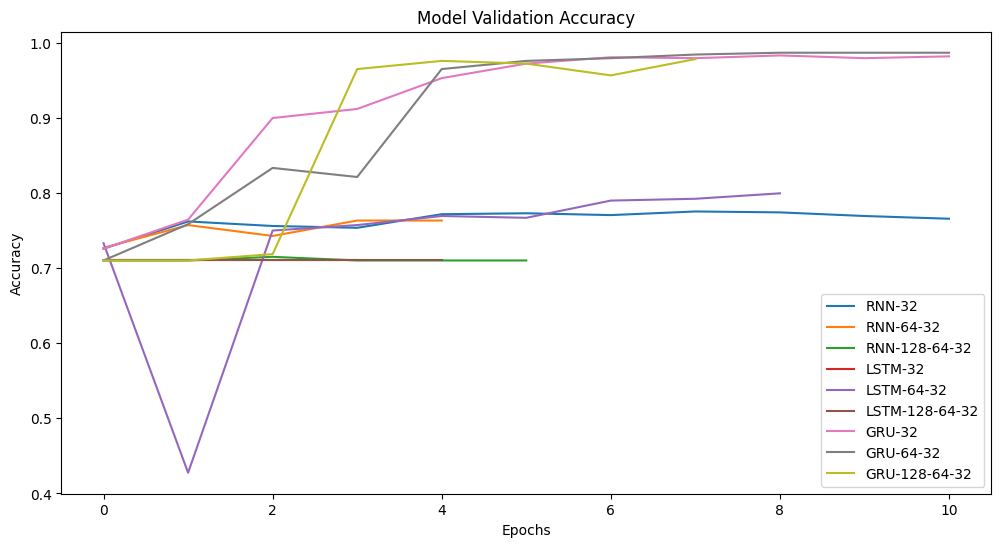

In [ ]:
# Plots
plt.figure(figsize = (12, 6))
for name, h in history.items():
  plt.plot(h.history['val_accuracy'], label = name)

plt.title('Model Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

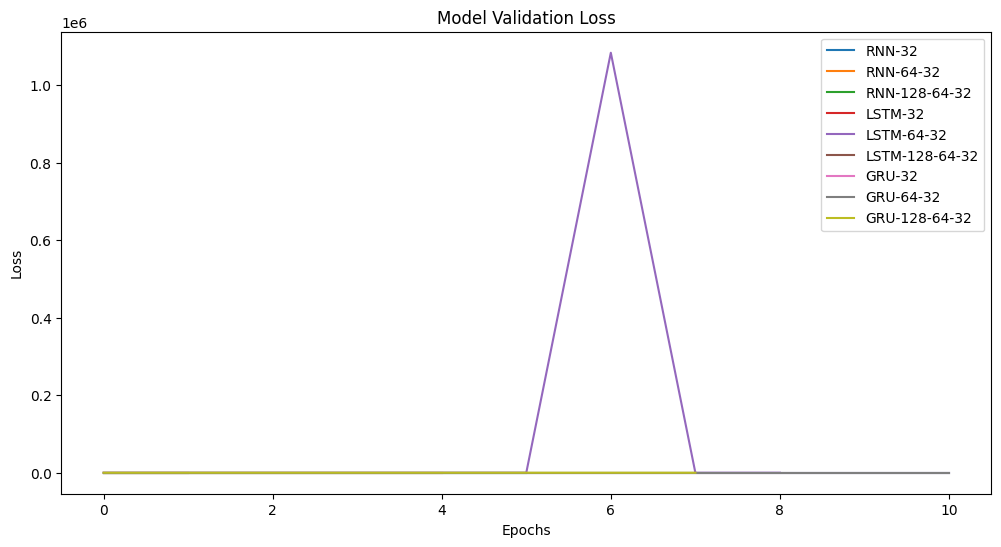

In [ ]:
# Plots
plt.figure(figsize = (12, 6))
for name, h in history.items():
  plt.plot(h.history['val_loss'], label = name)

plt.title('Model Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

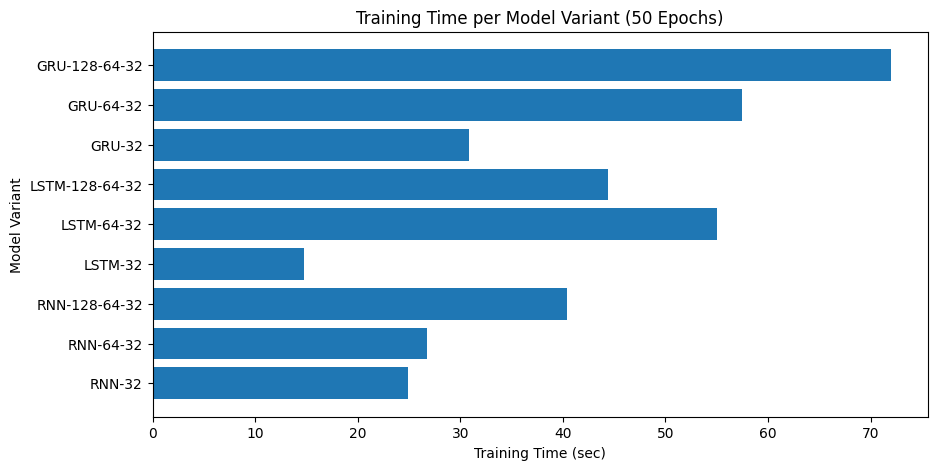

In [ ]:
# Runtime Bar Plot
plt.figure(figsize = (10, 5))
plt.barh(list(timings.keys()), list(timings.values()))
plt.title('Training Time per Model Variant (50 Epochs)')
plt.xlabel('Training Time (sec)')
plt.ylabel('Model Variant')
plt.show()

In [ ]:
# Save the tokenizer
import pickle
with open("tokenizer.pkl", "wb") as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
# === Step 1: Load tokenizer and best model ===
# Load your tokenizer
with open("tokenizer.pkl", "rb") as handle:
    tokenizer = pickle.load(handle)

# Load the best model (assuming it was saved as 'best_model_GRU-128-64-32.h5' or similar)
# You'll need to update the filename based on which model was best
best_model_name_from_results = max(results, key=lambda k: results[k][1]) # Get the name of the best model from the results dictionary
best_model_path = f"best_model_{best_model_name_from_results}.h5"

try:
    best_model = tf.keras.models.load_model(best_model_path)
    print(f"\n✅ Best Model Loaded: {best_model_name_from_results}")
except Exception as e:
    print(f"Could not load best model: {e}")


# === Step 2: Define prediction function ===
def predict_spam(texts, model, tokenizer, max_len=100, threshold=0.7):
    sequences = tokenizer.texts_to_sequences(texts)
    padded = pad_sequences(sequences, maxlen=max_len, padding='post', truncating='post')
    preds = model.predict(padded)
    results = ["HAM" if p <= threshold else "SPAM" for p in preds]
    return list(zip(texts, results))


# === Step 3: Test with new inputs ===
new_texts = [
    "Congratulations! You've won a $1000 Walmart gift card. Click here to claim.",
    "Hey,are we still on for lunch tomorrow?",
    "Urgent! Your account has been suspended. Update your details now."
    "Congratulations! You've won a free cruise.",
    "Let's meet for dinner tomorrow."
]


predictions = predict_spam(new_texts, best_model, tokenizer)
print("\n=== PREDICTIONS ===")
for text, label in predictions:
    print(f"{label}: {text}")


✅ Best Model Loaded: GRU-64-32
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 670ms/step

=== PREDICTIONS ===
SPAM: Congratulations! You've won a $1000 Walmart gift card. Click here to claim.
HAM: Hey,are we still on for lunch tomorrow?
SPAM: Urgent! Your account has been suspended. Update your details now.Congratulations! You've won a free cruise.
HAM: Let's meet for dinner tomorrow.
